In [4]:
import scipy.interpolate
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import enum, calendar, datetime
from scipy import optimize

In [5]:
# Creating the inputs

times = ['1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '12M']
deposits = [5.3305, 5.3315, 5.3165, 5.2905, 5.2605, 5.2355, 5.1983, 5.1625, 5.126, 5.0855, 5.047, 5.01345]

term_list = ['15M', '18M', '24M', '36M', '48M', '60M', '72M', '84M', '96M', '108M', '120M']
input_rate = [4.8525, 4.7225, 4.531, 4.2695, 4.119, 4.0305, 3.9825, 3.9525, 3.9335, 3.924, 3.9185]

deposit_data = pd.DataFrame(list(zip(times, deposits)), columns = ['term','deposits'])

swap_data = pd.DataFrame(list(zip(term_list, input_rate)), columns = ['term','rate'])

deposit_data

,term,deposits
0,1M,5.33050
1,2M,5.33150
2,3M,5.31650
3,4M,5.29050
4,5M,5.26050
5,6M,5.23550
6,7M,5.19830
7,8M,5.16250
8,9M,5.12600
9,10M,5.08550


In [20]:
swap_data

,term,rate
0,15M,4.8525
1,18M,4.7225
2,24M,4.5310
3,36M,4.2695
4,48M,4.1190
5,60M,4.0305
6,72M,3.9825
7,84M,3.9525
8,96M,3.9335
9,108M,3.9240


## date.py

In [7]:
import enum
from dataclasses import dataclass


class Tenor: 
    def __init__(self, s):
        try:
            assert isinstance(s, str)
            self.string = s
            self.n = s[:-1]
            self.n = int(self.n) if self.n != "" else 0
            self.unit = s[-1:]
            assert self.unit in ['F', 'D', 'M', 'Q', 'Y']
        except BaseException as ex:
            raise BaseException("Unable to parse tenor %s" % s) from ex

    def __str__(self):
        return self.string
    
class DCC(enum.Enum): # Day Count Convention
    ACT365 = 0
    ACT360 = 1

    def get_denominator(self):
        if self == DCC.ACT360:
            return 360.
        elif self == DCC.ACT365:
            return 365.
        assert False
     
@dataclass
class Convention:
    payment_frequency: Tenor
    dcc: DCC

In [8]:
excelBaseDate = datetime.date(1899, 12, 30)

def pydate_to_exceldate(d: dt.date) -> int:
    xldate = int((d - excelBaseDate).days)
    return xldate

def exceldate_to_pydate(d: int) -> dt.date:
    return excelBaseDate + relativedelta(days=d)

def create_excel_date(arg):
    if isinstance(arg, int):
        return arg
    elif isinstance(arg, datetime.date):
        return pydate_to_exceldate(arg)

def create_relativedelta(n: int, unit: str) -> relativedelta:
    if unit == 'M':
        return relativedelta(months=n)
    elif unit == 'D':
        return relativedelta(days=n)
    elif unit == 'Y':
        return relativedelta(years=n)
    elif unit == 'Q':
        return relativedelta(months=3 * n)
    else:
        raise BaseException("Unknown unit %s" % unit)
        
def date_step(date: int, step_size: int, step_unit: str, preserve_eom: bool = False):
    pydate = exceldate_to_pydate(date)
    pydate2 = pydate + create_relativedelta(step_size, step_unit)
    if preserve_eom:
        lastDay = calendar.monthrange(pydate.year, pydate.month)[1]
        if pydate.day == lastDay: # if the original date is the EOM
            d2 = calendar.monthrange(pydate2.year, pydate2.month)[1]
            pydate2 = datetime.date(pydate2.year, pydate2.month, d2)
    date2 = pydate_to_exceldate(pydate2)
    return date2

def generate_schedule(start: int, end: int, step: int, unit: str): 
    d = end
    out = []
    stepinv = -step
    while d > start:
        out.append(d)
        d = date_step(d, stepinv, unit)
    if out[-1] != start:
        out.append(start)
    return np.array(out[::-1])
    
def calculate_dcf(date0, date1, basis):
    numerator = date1 - date0
    return numerator / basis 

def calculate_dcfs(dates, basis):
    numerator = dates[1:] - dates[:-1]
    return numerator / basis 

In [9]:
# Calender Functions

from dateutil.easter import * 

def is_weekend(date: int):
    date = exceldate_to_pydate(date)
    dow = date.isoweekday()
    # 1,2,3,4,5 is Monday to Friday
    # 6,7 is Saturday, Sunday
    return dow >= 6

def find_weekday(DOW_target: int, yyyy: int, mm: int, count: int, ascending: bool = True): # ex: "Third Monday of Janurary"
    d = dt.date(yyyy, mm, 1)
    if ascending:
        dow = d.isoweekday()
        offset = (DOW_target + 7 - dow) % 7
    else: 
        d = last_day(yyyy,mm)
        dow = d.isoweekday()
        offset = (dow + 7 - DOW_target) % 7
    if count > 1:
        offset += 7*(count-1)
    if ascending:
        return d + relativedelta(days=offset)
    else: 
        return d - relativedelta(days=offset)

def is_USHoliday(t: dt.date):
    yy = t.year
    e = easter(yy)
    
    # MLK, New Year, Presidents, Juneteenth, Indepednece, Labor, Columbus, Veterans, Thanksgiving, Christmas
    if (t == find_weekday(1,yy,1,3) or t == dt.date(yy,1,1) or t == find_weekday(1,yy,2,3) 
    or t == e or t == e - relativedelta(days=2) or t == e - relativedelta(days=1) or t == dt.date(yy,6,19)
    or t == dt.date(yy,7,4) or t == find_weekday(1,yy,2,3) or t == find_weekday(1,yy,10,2)
    or t == dt.date(yy,11,11) or t == find_weekday(4,yy,11,4) or t == dt.date(yy,12,25)):
        return True
    else:
        return False
    
def date_roll(date: int, country: str): 
    if country == 'US':
        while is_weekend(date): date += 1
        while is_USHoliday(exceldate_to_pydate(date)): date += 1
    return date

In [10]:
# Function: preprocess_deposits creates the dates and calculates discount factors
# Input: eval_date: datetime object, deposit_data['term','deposits'] DataFrame, 
# Output: df_data[start_date, maturity_date, df] DataFrame

def preprocess_deposits(eval_date, deposit_data, dcc):
    index = []
    index.append(eval_date)
    for timedelta in deposit_data['term']:
        tenor = Tenor(timedelta)
        date = eval_date + create_relativedelta(tenor.n, tenor.unit)
        
        # Date roll occurs in Excel Date format, must convert
        d_int = date_roll(pydate_to_exceldate(date), 'US')        
        index.append(exceldate_to_pydate(d_int))
        
    df = []
    for i in range(1, len(index)):
        delta = ((index[i] - index[0]).days)/dcc.get_denominator()
        df_ = 1 / (1 + deposit_data['deposits'][i-1]/100 * delta)
        df.append(df_)
    
    data = pd.DataFrame(list(zip(index[1:], df)), columns = ['date','df'])
    return data

spot = dt.date(2024, 3, 25)
df_data = preprocess_deposits(spot, deposit_data, DCC.ACT360)
df_data

,date,df
0,2024-04-25,0.995431
1,2024-05-27,0.990756
2,2024-06-25,0.986596
3,2024-07-25,0.982387
4,2024-08-26,0.977992
5,2024-09-25,0.973938
6,2024-10-25,0.970025
7,2024-11-25,0.966059
8,2024-12-26,0.962187
9,2025-01-27,0.958305


## curve.py

- *Discount factors* allow one to calculate present value of money recieved in the future
- *Forward rates* allow one to make assumptions as to the future level of rates

A zero coupon bond for maturity T is an instrument which pay $1 T years from now (market value = P(0,T)). 

P(t,T) = P(0,T)/P(0,t) < 1

In [11]:
class ExponentialInterpolator:
    def __init__(self, interp):
        self.interp = interp

    def value(self, t):
        return np.exp(self.interp(t))
    
class Curve:
    def __init__(self, eval_date, dates, dfs, interpolation_mode): 
        try:
            spot = pydate_to_exceldate(eval_date)
            times = [pydate_to_exceldate(date) for date in dates]
            self.times = np.append(spot, times)
            self.dfs = np.append(1.0, dfs)
            self.interpolation_mode = 'linear'
            
        except BaseException as ex:
            raise BaseException("Unable to create curve")        
        
    def set_interpolator(self):
        logdf = np.log(self.dfs)
        interp = scipy.interpolate.interp1d(self.times, logdf, self.interpolation_mode, fill_value='extrapolate') 
        self.interpolator = ExponentialInterpolator(interp)

    def get_df(self, t):
        return self.interpolator.value(t)
    
    def set_df(self, d, df):
        xd = pydate_to_exceldate(d)
        if np.in1d(xd,self.times):
            idx = np.searchsorted(self.times, xd)
            self.dfs[idx] = df
        else:
            self.times = np.append(self.times, xd)
            self.dfs = np.append(self.dfs, df)
        self.set_interpolator()
        
    def get_fwd_rate(self, t_start, t_end):
        dfs_start = self.get_df(t_start)
        dfs_end = self.get_df(t_end)
        dcf = calculate_dcf(t_start, t_end)
        return (dfs_start / dfs_end - 1) / dcf
    
    def get_fwd_rate_aligned(self, t):
        dfs = self.get_df(t)
        df1 = dfs[:-1]
        df2 = dfs[1:]
        dcf = calculate_dcfs(t, 360)
        return (df1 / df2 - 1) / dcf
        
    def get_zero_rate(self, t):
        dfs = self.get_df(t)
        dcf = calculate_dcf(self.times[0], t, 360)
        return (1 / dfs - 1) / dcf

### Curve test

In [12]:
spot_date = dt.date(2024, 3, 25)
disc_curve = Curve(spot_date, df_data['date'], df_data['df'], 'linear')
disc_curve.set_interpolator()

print(len(disc_curve.dfs))
type(disc_curve.dfs[4])

13


numpy.float64

## curveplotter.py

In [13]:
class PlotMode(enum.Enum):
    DF = 0
    ZR = 1
    FWD = 2
    
class CurvePlotter:
    def __init__(self, curve: Curve, samples: int, date_mode: str, mode = PlotMode.DF): 
        self.curve = curve
        self.mode = mode
        self.samples = samples
        self.date_mode = date_mode
        
    def plot(self):
        timesample_excel = np.linspace(self.curve.times[0], self.curve.times[-1], self.samples)
        timesample_pydate = [exceldate_to_pydate(t) for t in timesample_excel]
        
        if self.date_mode == 'excel':
            timesample = timesample_excel
        elif self.date_mode == 'pydate': 
            timesample = timesample_pydate
            
        y_new = self.curve.get_df(timesample_excel)
        zero_rate = self.curve.get_zero_rate(timesample_excel[1:])
        fwd = self.curve.get_fwd_rate_aligned(timesample_excel)
        
        if self.mode == PlotMode.DF:
            plt.figure(figsize=(10,6))
            plt.plot(timesample, y_new)
            plt.xlabel("Time")
            plt.ylabel("Rate")
            plt.show()
            
        elif self.mode == PlotMode.ZR:
            plt.figure(figsize=(10,6))
            plt.plot(timesample[1:], zero_rate)
            plt.xlabel("Time")
            plt.ylabel("Rate")
            plt.show()
            
        elif self.mode == PlotMode.FWD:
            plt.figure(figsize=(10,6))
            plt.plot(timesample[1:], fwd)
            plt.xlabel("Time")
            plt.ylabel("Rate")
            plt.show()
    
        else:
            raise BaseException("Unknown Plotting Mode")

### Curve Plotter Unit Test

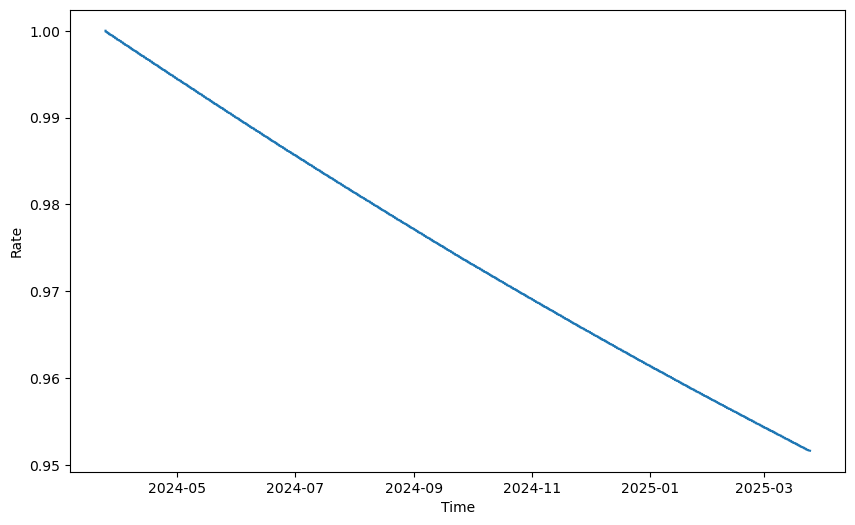

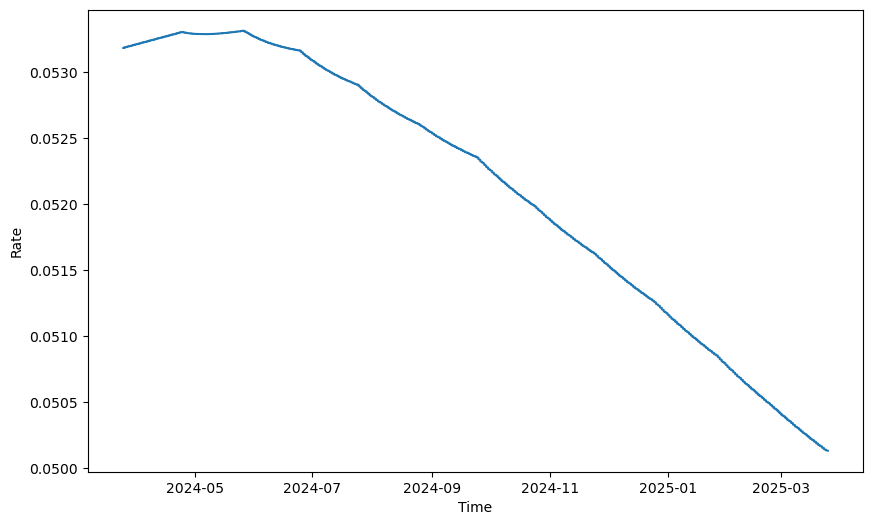

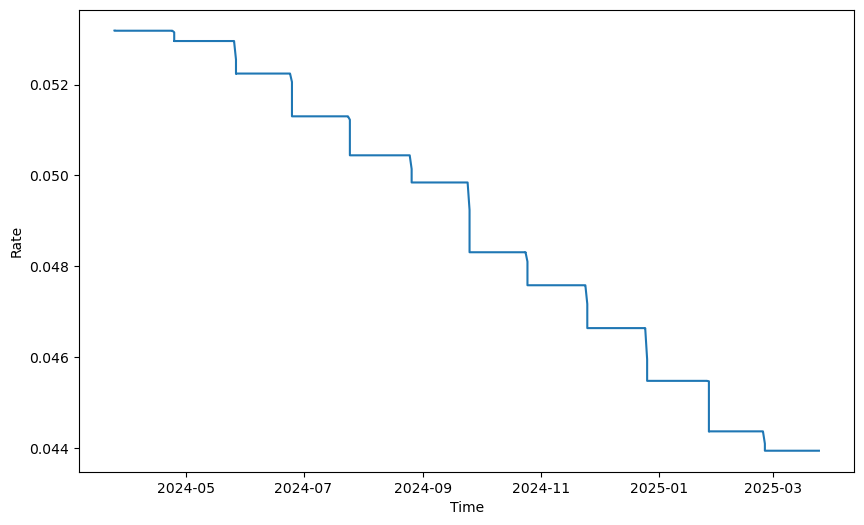

In [14]:
dcurve = CurvePlotter(disc_curve, 1000, 'pydate', PlotMode.DF)
dcurve.plot()

zrcurve = CurvePlotter(disc_curve, 1000, 'pydate', PlotMode.ZR)
zrcurve.plot()

fcurve = CurvePlotter(disc_curve, 1000, 'pydate', PlotMode.FWD)
fcurve.plot()

## curveswap.py

In [15]:
class CurveSwap:
    def __init__(self, curve_discount: Curve, start: dt.date, length_size: int, length_unit: str, basis=360):
        self.basis = basis
        self.curve_discount = curve_discount
        self.start = pydate_to_exceldate(start) 
        self.end = date_step(self.start, length_size, length_unit)
        self.accruals_fixed = generate_schedule(self.start, self.end, 1, 'Y')
        self.dcf_fixed = calculate_dcfs(self.accruals_fixed, self.basis)
 
    def calc_par_rate(self, dcurve): 
        df = dcurve.get_df(self.accruals_fixed)
        denominator = sum(self.dcf_fixed * df[1:])
        df_end = dcurve.get_df(self.end)
        return (1 - df_end) / denominator

In [21]:
def preprocess_swap_rate(eval_date, swap_data):
    index = []
    index.append(eval_date)
    for timedelta in swap_data['term']:
        tenor = Tenor(timedelta)
        date = eval_date + create_relativedelta(tenor.n, tenor.unit)
        # Date roll occurs in Excel Date format, must convert
        d_int = date_roll(pydate_to_exceldate(date), 'US')        
        index.append(exceldate_to_pydate(d_int))   
    df_guess = []
    for i in range(1, len(index)):
        delta = ((index[i] - index[0]).days)/DCC.ACT360.get_denominator()
        df_ = 1 / (1 + swap_data['rate'][i-1]/100 * delta)
        df_guess.append(df_)
    data = pd.DataFrame(list(zip(index[1:], swap_data['term'], swap_data['rate'], df_guess)), columns = ['date','term','rate','guess_df'])
    return data

spot = dt.date(2024, 3, 25)
guessed_data = preprocess_swap_rate(spot, swap_data)
guessed_data

,date,term,rate,guess_df
0,2025-06-25,15M,4.8525,0.941975
1,2025-09-25,18M,4.7225,0.932820
2,2026-03-25,24M,4.5310,0.915853
3,2027-03-25,36M,4.2695,0.885062
4,2028-03-27,48M,4.1190,0.856611
5,2029-03-26,60M,4.0305,0.830187
6,2030-03-25,72M,3.9825,0.804907
7,2031-03-25,84M,3.9525,0.780867
8,2032-03-25,96M,3.9335,0.757995
9,2033-03-25,108M,3.9240,0.736224


In [22]:
def boostrap_curve(eval_date, swap_data, disc_curve: Curve):
    
    for idx, term in enumerate(swap_data['term']):
        tenor = Tenor(term)
        swap = CurveSwap(disc_curve, spot_date, tenor.n, tenor.unit)
        target = swap_data['rate'][idx]/100

        def g(x):
            disc_curve.set_df(swap_data['date'][idx], x)
            curv_rate = swap.calc_par_rate(disc_curve)
            return target - curv_rate

        y = optimize.newton(g, swap_data['guess_df'][idx])
        disc_curve.set_df(swap_data['date'][idx], y)
        
    return disc_curve
   
boostrap_curve(spot, guessed_data, disc_curve).dfs

array([1.        , 0.99543082, 0.99075612, 0.98659551, 0.98238687,
       0.977992  , 0.97393817, 0.97002524, 0.9660588 , 0.9621867 ,
       0.95830485, 0.95488591, 0.95162798, 0.94144717, 0.93187292,
       0.91428142, 0.88108801, 0.84952889, 0.81935903, 0.78970398,
       0.76079987, 0.7326506 , 0.70523838, 0.67854508])

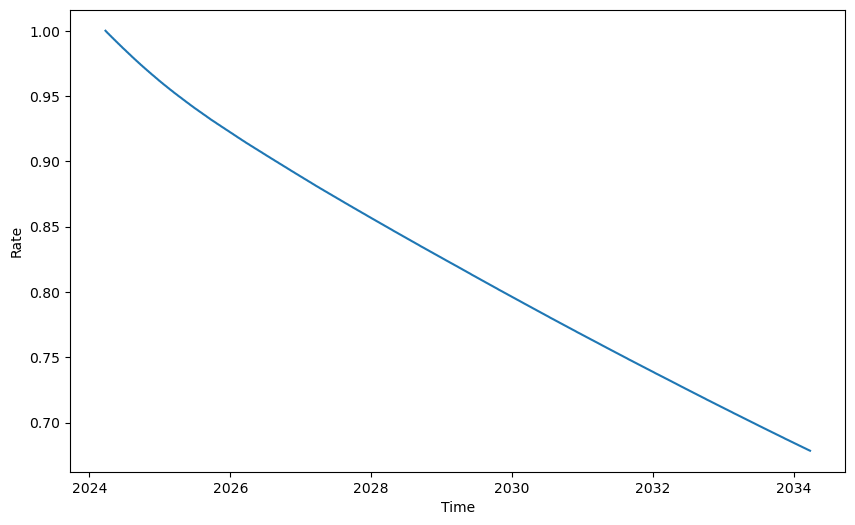

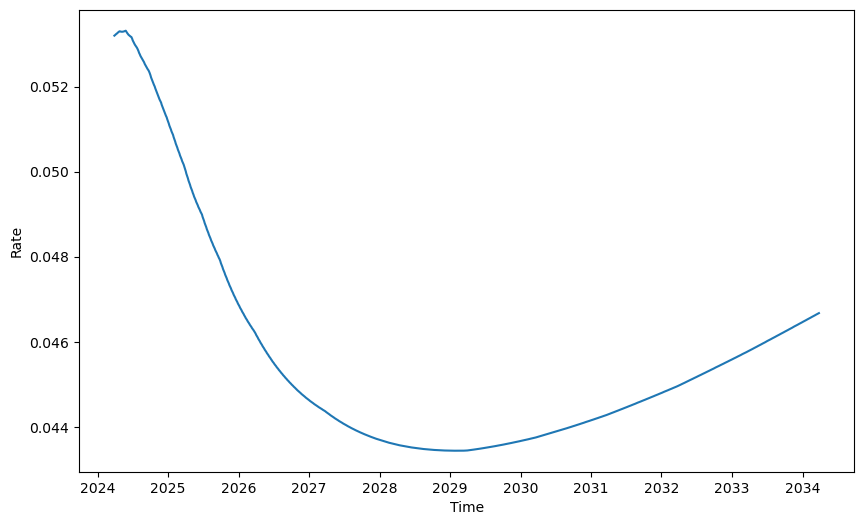

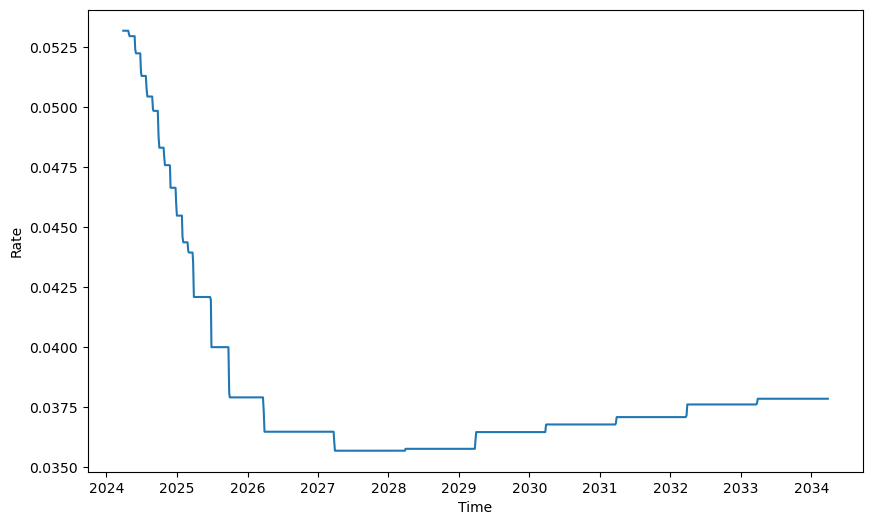

In [15]:
dcurve.plot()

zrcurve.plot()

# fcurve = CurvePlotter(disc_curve, 1000, PlotMode.FWD)
fcurve.plot()

## curvemaker.py

The reason I kept getting errors was because the initalized times array was converted into Datetime objects, which became relativedelta when calculating dts and then not exponentiable. Fixed because converting to excel date smoothes over type errors. 

In [16]:
import random

class CurveMaker:
    @staticmethod # No constructor needed
    def makeCurveFromShortRateModel(times, r0: float, speed: float, r_mean: float, sigma: float, 
                                    interpolation_mode):
        r = r0
        timesxl = np.array([pydate_to_exceldate(t) for t in times])
        rates = []
        dts = timesxl[1:] - timesxl[:-1]
        dts = dts / 365.
        for dt_ in dts: 
            rates.append(r)
            dr = speed * (r_mean - r) * dt_ + sigma * random.gauss(0.0, 1.0) * dt_**.5
            r += dr
    
        rates = np.array(rates)
        dfs_fwd = np.exp(-rates * dts)
        dfs = np.cumprod(dfs_fwd)
        return Curve(eval_date=times[0], dates = times[1:], dfs=dfs, interpolation_mode=interpolation_mode)

In [19]:
def test_short_rate_model():
    times = [exceldate_to_pydate(i) for i in range(2, 2 + 80 * 365 + 1, 180)]
    curve = CurveMaker.makeCurveFromShortRateModel(times, r0=0.022, speed=0.0001,
                                                r_mean=0.05, sigma=0.0005,
                                                interpolation_mode='linear')
    curve.set_interpolator()
    dcurve = CurvePlotter(curve, 1000, 'pydate', PlotMode.DF)
    dcurve.plot()
    zrcurve = CurvePlotter(curve, 1000, 'pydate', PlotMode.ZR)
    zrcurve.plot()
    fcurve = CurvePlotter(curve, 1000, 'pydate', PlotMode.FWD)
    fcurve.plot()

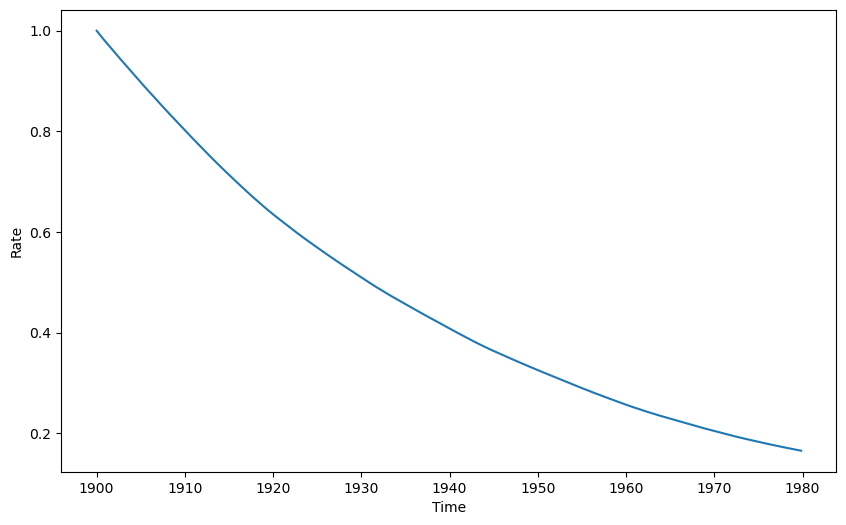

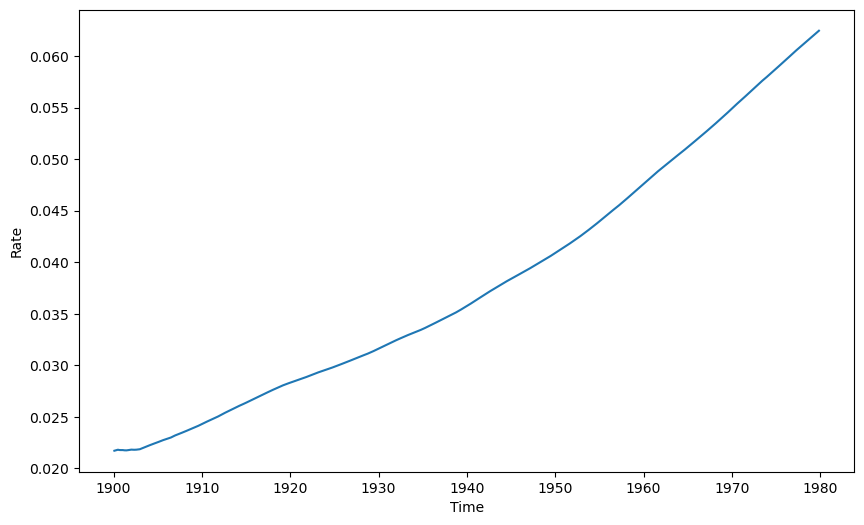

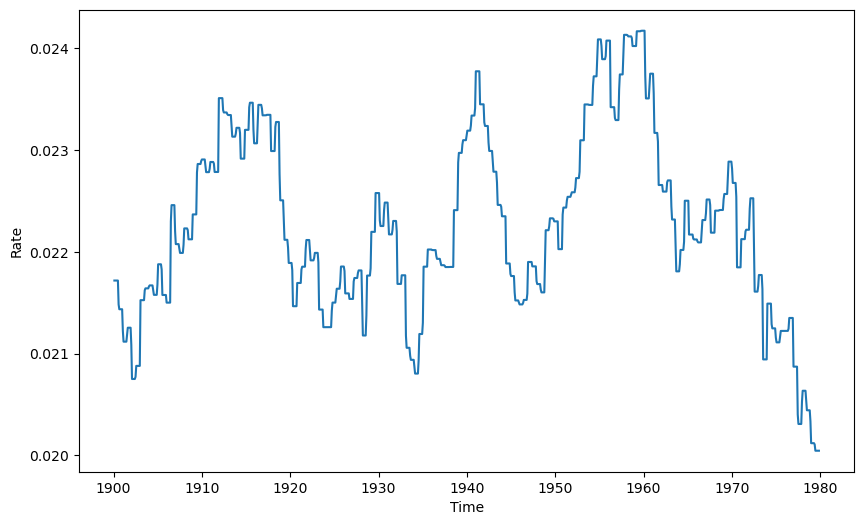

In [20]:
test_short_rate_model()

## stdcurveswap.py

Pass in the unfinished forward and the bootstrapped discount, it will bootstrap the forward curve

In [ ]:
class CurveMap:
     def __init__(self):
        self.curves = collections.OrderedDict()

    def add_curve(self, c, name: str):
        assert_type(c, Curve)
        self.curves[name] = c
        
class StdCurveSwap:
    def __init__(self, curve_forecast: str, curve_discount: str, start: dt.date, 
                 length_size: int, length_unit: str, 
                 convention_fixed: Convention, convention_float: Convention):
        self.convention_fixed = convention_fixed
        self.convention_float = convention_float
        self.curve_forecast = curve_forecast
        self.curve_discount = curve_discount
        self.start = pydate_to_exceldate(start)
        self.end = date_step(self.start, length_size, length_unit)
        self.accruals_fixed = generate_schedule(self.start, self.end, 
                                                self.convention_fixed.payment_frequency.n, self.convention_fixed.payment_frequency.unit)
        self.accruals_float = generate_schedule(self.start, self.end, 
                                               self.convention_float.payment_frequency.n, self.convention_float.payment_frequency.unit)
        self.dcf_fixed = calculate_dcfs(self.accruals_fixed)
        self.dcf_float = calculate_dcfs(self.accruals_float)
    
    def get_par_rate(self, curvemap):
        fcurve = curvemap[self.curve_forecast]
        dcurve = curvemap[self.curve_discount]
        r = fcurve.get_fwd_rate_aligned(accruals_float)
        df = dcurve.get_df(self.accruals_fixed)
        numerator = sum(r * self.dcf_float * df[1:])
        denominator = sum(self.dcf_fixed * df[1:])
        return numerator / denominator